In [1]:
import requests
import zipfile
import os
import datetime
from io import BytesIO
import xarray  as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import glob

In [2]:
def download_ampere_data(username, start_date, data_type, hemisphere=None, days=1):
    base_url = f"https://ampere.jhuapl.edu/services/data-{data_type}.php"
    start_datetime = datetime.datetime.strptime(start_date, "%Y-%m-%dT%H:%M")
    current_datetime = start_datetime
    end_datetime = start_datetime + datetime.timedelta(days=days)
    zip_buffer = BytesIO()

    with zipfile.ZipFile(zip_buffer, 'w', zipfile.ZIP_DEFLATED) as zip_file:
        while current_datetime < end_datetime:
            next_datetime = current_datetime + datetime.timedelta(days=7)
            start_str = current_datetime.strftime("%Y-%m-%dT%H:%M")
            end_str = next_datetime.strftime("%Y-%m-%dT%H:%M")
            params = {
                'logon': username,
                'start': start_str,
                'end': end_str,
            }
            if data_type in ['grd', 'ird']:
                params['pole'] = hemisphere

            response = requests.get(base_url, params=params)
            if response.status_code == 200:
                file_name = f"{data_type}_{current_datetime.strftime('%Y%m%d_%H%M')}_to_{next_datetime.strftime('%Y%m%d_%H%M')}.nc"
                zip_file.writestr(file_name, response.content)
            else:
                print(f"Failed to download data for {start_str} to {end_str}")

            current_datetime = next_datetime

    zip_buffer.seek(0)
    with open(f"{data_type}_data.zip", 'wb') as f:
        f.write(zip_buffer.read())

# Example usage:
#download_ampere_data(
#    username='sachinreddy',
#    start_date='2010-08-07T00:00',
#    data_type='grd',  
#    hemisphere='north',  #or south
#    days = 1
#)


In [120]:
def open_multiple_nc(nc_files):
    ds = xr.open_mfdataset(nc_files, concat_dim='nRec', combine='nested', parallel=True)
    return ds

dir = '/home/sachin/Documents/NIPR/Research/Data/AMPERE/2010/*.nc'
open_multi_amp = open_multiple_nc(dir)
open_multi_amp


<xarray.Dataset> Size: 55GB
Dimensions:       (nRec: 220129, nObs: 1200, vComp: 3)
Dimensions without coordinates: nRec, nObs, vComp
Data variables: (12/34)
    npnt          (nRec) int16 440kB dask.array<chunksize=(720,), meta=np.ndarray>
    year          (nRec) int16 440kB dask.array<chunksize=(720,), meta=np.ndarray>
    doy           (nRec) int16 440kB dask.array<chunksize=(720,), meta=np.ndarray>
    time          (nRec) float32 881kB dask.array<chunksize=(720,), meta=np.ndarray>
    avgint        (nRec) int16 440kB dask.array<chunksize=(720,), meta=np.ndarray>
    kmax          (nRec) int16 440kB dask.array<chunksize=(720,), meta=np.ndarray>
    ...            ...
    del_db_geo    (nRec, nObs, vComp) float64 6GB dask.array<chunksize=(720, 1200, 3), meta=np.ndarray>
    del_jPar      (nRec, nObs) float64 2GB dask.array<chunksize=(720, 1200), meta=np.ndarray>
    del_db_Th_Th  (nRec, nObs) float64 2GB dask.array<chunksize=(720, 1200), meta=np.ndarray>
    del_db_Ph_Th  (nRec, nObs) float64 2GB dask.array<chunksize=(720, 1200), meta=np.ndarray>
    del_db_Th_Ph  (nRec, nObs) float64 2GB dask.array<chunksize=(720, 1200), meta=np.ndarray>
    del_db_Ph_Ph  (nRec, nObs) float64 2GB dask.array<chunksize=(720, 1200), meta=np.ndarray>
Attributes:
    title:        Ampere data for 2010-03-01 00:00 - 2010-03-02 00:00.
    description:  AMPERE GRD data (fitted magnetic pertubation data).
    created:      2022-09-09T22:29:05-04:00

In [121]:
def create_datetime(ds):

    ds = ds.copy()

    fractional_hours = ds['time'].values
    year = ds['year'].values
    doy = ds['doy'].values

    #fractional_hours = [i/30 for i in range(720)]
    df = pd.DataFrame({'fractional_hours': fractional_hours})
    df['hours'] = df['fractional_hours'].apply(lambda x: int(x))
    df['minutes'] = df['fractional_hours'].apply(lambda x: int((x * 60) % 60))
    df['time'] = df.apply(lambda row: f"{int(row['hours']):02}:{int(row['minutes']):02}", axis=1)
    df['doy'] = doy
    df['year'] = year

    def doy_year_to_date(year, doy):
        return datetime.datetime(year, 1, 1) + datetime.timedelta(int(doy) - 1)

    df['date'] = df.apply(lambda row: doy_year_to_date(row['year'], row['doy']), axis=1)
    df['date'] = df['date'].dt.strftime('%Y-%m-%d')

    dt  = pd.to_datetime(df['date'] + ' ' + df['time'])

    ds['dt'] = dt
    
    #ds = ds.set_coords('dt')
    ds = ds.sortby('dt')

    return ds

#open_amp = create_datetime(xr.open_dataset('/home/sachin/Documents/NIPR/Research/Data/AMPERE/ampere.20100807.k060_m08.north.grd.nc'))
open_amp = create_datetime(open_multi_amp)
open_amp

<xarray.Dataset> Size: 55GB
Dimensions:       (nRec: 220129, nObs: 1200, vComp: 3, dim_0: 220129)
Coordinates:
  * dim_0         (dim_0) int64 2MB 0 1 2 3 4 ... 220125 220126 220127 220128
Dimensions without coordinates: nRec, nObs, vComp
Data variables: (12/35)
    npnt          (nRec) int16 440kB dask.array<chunksize=(720,), meta=np.ndarray>
    year          (nRec) int16 440kB dask.array<chunksize=(720,), meta=np.ndarray>
    doy           (nRec) int16 440kB dask.array<chunksize=(720,), meta=np.ndarray>
    time          (nRec) float32 881kB dask.array<chunksize=(720,), meta=np.ndarray>
    avgint        (nRec) int16 440kB dask.array<chunksize=(720,), meta=np.ndarray>
    kmax          (nRec) int16 440kB dask.array<chunksize=(720,), meta=np.ndarray>
    ...            ...
    del_jPar      (nRec, nObs) float64 2GB dask.array<chunksize=(720, 1200), meta=np.ndarray>
    del_db_Th_Th  (nRec, nObs) float64 2GB dask.array<chunksize=(720, 1200), meta=np.ndarray>
    del_db_Ph_Th  (nRec, nObs) float64 2GB dask.array<chunksize=(720, 1200), meta=np.ndarray>
    del_db_Th_Ph  (nRec, nObs) float64 2GB dask.array<chunksize=(720, 1200), meta=np.ndarray>
    del_db_Ph_Ph  (nRec, nObs) float64 2GB dask.array<chunksize=(720, 1200), meta=np.ndarray>
    dt            (dim_0) datetime64[ns] 2MB 2010-03-01 ... 2010-12-31T23:58:00
Attributes:
    title:        Ampere data for 2010-03-01 00:00 - 2010-03-02 00:00.
    description:  AMPERE GRD data (fitted magnetic pertubation data).
    created:      2022-09-09T22:29:05-04:00

In [122]:
def create_new_ds(ds):

    ds = ds.copy()
    jPar = ds['jPar'].values
    dt = ds['dt'].values
    mlat = np.linspace(50, 90, 50)
    mlt = np.linspace(0, 24, 24)

    ds_new = xr.Dataset({'jPar': (['dt','mlat','mlt'], jPar.reshape(-1, 50, 24))},
                        coords={'dt': dt,'mlat': mlat,'mlt': mlt})

    #ds_new = ds_new.sel(dt=slice('2010-08-01 00:00:00', '2010-08-01 23:30:00'))

    return ds_new

ds = create_new_ds(open_amp)
ds

<xarray.Dataset> Size: 2GB
Dimensions:  (dt: 220129, mlat: 50, mlt: 24)
Coordinates:
  * dt       (dt) datetime64[ns] 2MB 2010-03-01 ... 2010-12-31T23:58:00
  * mlat     (mlat) float64 400B 50.0 50.82 51.63 52.45 ... 88.37 89.18 90.0
  * mlt      (mlt) float64 192B 0.0 1.043 2.087 3.13 ... 20.87 21.91 22.96 24.0
Data variables:
    jPar     (dt, mlat, mlt) float64 2GB 0.0004268 -0.02544 ... 0.01465 0.01318

In [123]:
def get_omni(df):
    df = df.copy()
    df['dt'] = df['Timestamp_1min_omni']
    df['dt'] = pd.to_datetime(df['dt'])
    df = df.set_index('dt')
    df = df.drop(columns=['Timestamp_1min_omni','Timestamp_1hr_omni'])

    ds = xr.Dataset.from_dataframe(df)

    return ds

omni_ds = get_omni(pd.read_csv('/home/sachin/Documents/NIPR/Research/Data/OMNI/omni_hro_1min_2010.csv'))
omni_ds

<xarray.Dataset> Size: 50MB
Dimensions:         (dt: 525600)
Coordinates:
  * dt              (dt) datetime64[ns] 4MB 2010-01-01 ... 2010-12-31T23:59:00
Data variables:
    BX_GSE          (dt) float64 4MB 0.02 0.13 0.14 0.04 ... -1.79 1e+04 -1.41
    BY_GSE          (dt) float64 4MB 2.98 2.96 2.99 3.01 ... 3.54 1e+04 3.69
    BZ_GSE          (dt) float64 4MB -0.39 -0.51 -0.37 ... -2.06 1e+04 -2.45
    flow_speed      (dt) float64 4MB 283.2 283.2 283.9 ... 1e+05 1e+05 1e+05
    proton_density  (dt) float64 4MB 3.85 3.85 3.92 3.92 ... 1e+03 1e+03 1e+03
    AL_INDEX        (dt) int64 4MB -1 -1 -1 -1 -2 -2 ... -37 -36 -35 -35 -35 -36
    AU_INDEX        (dt) int64 4MB 3 3 3 3 3 3 3 3 3 ... 10 11 11 10 10 9 9 10
    SYM_H           (dt) int64 4MB 1 1 1 1 1 1 1 ... -16 -17 -17 -17 -17 -17 -17
    ASY_H           (dt) int64 4MB 10 10 10 10 10 11 11 11 ... 8 8 9 9 8 9 9 8
    F10.7           (dt) float64 4MB 72.7 72.7 72.7 72.7 ... 87.9 87.9 87.9 87.9
    Kp              (dt) int64 4MB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3

In [125]:
#merge omni and ampere data
def merge_omni_ampere(omni_ds, ampere_ds):
    ds = xr.merge([omni_ds, ampere_ds], join='right')
    #ds = ds.sel(dt=slice('2010-08-01','2010-08-02'))
    #save ds_new to netcdf
    ds.to_netcdf('/home/sachin/Documents/NIPR/Research/Data/AMPERE/processed/ampere_omni_2010.nc')
    
    return ds

merge_omni_ampere(omni_ds, ds)

<xarray.Dataset> Size: 2GB
Dimensions:         (dt: 220129, mlat: 50, mlt: 24)
Coordinates:
  * dt              (dt) datetime64[ns] 2MB 2010-03-01 ... 2010-12-31T23:58:00
  * mlat            (mlat) float64 400B 50.0 50.82 51.63 ... 88.37 89.18 90.0
  * mlt             (mlt) float64 192B 0.0 1.043 2.087 3.13 ... 21.91 22.96 24.0
Data variables:
    BX_GSE          (dt) float64 2MB -0.96 -0.96 -1.07 ... -3.79 -3.99 1e+04
    BY_GSE          (dt) float64 2MB 0.45 0.23 0.52 0.86 ... 2.4 2.36 2.04 1e+04
    BZ_GSE          (dt) float64 2MB -0.06 -0.28 -0.36 -0.5 ... -0.15 0.42 1e+04
    flow_speed      (dt) float64 2MB 338.8 338.0 338.6 ... 318.7 1e+05 1e+05
    proton_density  (dt) float64 2MB 15.98 15.91 15.95 ... 4.41 1e+03 1e+03
    AL_INDEX        (dt) int64 2MB -41 -41 -42 -26 -29 ... -39 -37 -37 -36 -35
    AU_INDEX        (dt) int64 2MB 32 37 43 49 37 48 46 ... 14 15 11 10 11 10 9
    SYM_H           (dt) int64 2MB 5 5 5 4 5 5 5 ... -16 -16 -16 -16 -16 -17 -17
    ASY_H           (dt) int64 2MB 16 15 15 15 15 15 14 14 ... 7 7 7 8 8 8 9 9
    F10.7           (dt) float64 2MB 76.5 76.5 76.5 76.5 ... 87.9 87.9 87.9 87.9
    Kp              (dt) int64 2MB 13 13 13 13 13 13 13 13 ... 3 3 3 3 3 3 3 3
    jPar            (dt, mlat, mlt) float64 2GB 0.0004268 -0.02544 ... 0.01318

<>:38: SyntaxWarning: invalid escape sequence '\p'
<>:38: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_5602/2810310008.py:38: SyntaxWarning: invalid escape sequence '\p'
  plt.colorbar(c, ax=ax, label='J$_\parallel$ (FAC) [µA/m$^2$]', shrink=0.3, pad = 0.12,


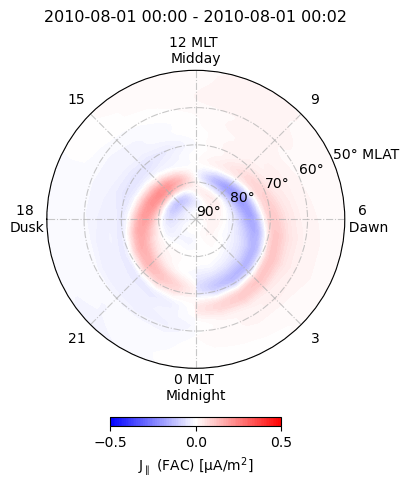

In [119]:
fac = ds['jPar'].mean(dim='dt').values

def dt_to_str(dt):
    dt_1 = dt[0]
    dt_2 = dt[1] 
    time_1 = pd.to_datetime(dt_1)
    time_2 = pd.to_datetime(dt_2)
    str_time_1 = time_1.strftime('%Y-%m-%d %H:%M')
    str_time_2 = time_2.strftime('%Y-%m-%d %H:%M')

    return str_time_1, str_time_2

dt = open_amp['dt'].values
start_time, end_time = dt_to_str(dt)

fac = fac.reshape(24, 50).T # reshape and transpose
fac = np.flipud(fac) # flip the array upside down
theta = np.linspace(0, 360, 24) - 90 # rotate by 90 degrees
theta = np.radians(theta) # convert to radians
r = 90 - np.linspace(40, 90, 50) #convert to colat

cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", ["blue","blue", "white", "white","red","red"])
cmap = 'bwr'

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 5))

c = ax.contourf(theta, r, fac, cmap=cmap, levels=np.linspace(-0.5,.5 , 100))
ax.set_ylim([0,40])
ax.set_yticks([0, 10, 20, 30,40])
ax.set_yticklabels(["90°", "80°", "70°", "60°","50° MLAT"])
ax.set_xlim([-np.pi, np.pi])
ax.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
ax.set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n  Dawn", "9", "12 MLT \nMidday", "15", "18 \nDusk"])
ax.grid(True, linestyle='-.', alpha=0.7)
ax.set_title(f"{start_time} - {end_time}", pad=10, fontsize=11.5)


plt.colorbar(c, ax=ax, label='J$_\parallel$ (FAC) [µA/m$^2$]', shrink=0.3, pad = 0.12, 
             ticks=[-0.5, 0,  0.5], 
             orientation='horizontal')

plt.tight_layout()
#plt.savefig('ampere_20100807.png', dpi=400)